In [3]:
# Import packages
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

import zipfile
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import Naive
from sklearn.metrics import mean_absolute_error # Optional, for evaluation if needed


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
# --- 1. Load and Prepare Data ---
# Load daily aggregated data
df = pd.read_csv('/Users/noeespinosa/Documents/10-Data-analysis/00-capstone-project/Watts_UP-Hydropower_Climate_Optimisation/data/daily_merged_hydro_climate.csv')

# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03,consumer_device_3_data_user_9,0.000576,0.08,0.006786,0.005324,0.000922,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,9,1.344820,0,0,1
1,2023-06-03,consumer_device_3_data_user_4,0.000647,0.09,0.007634,0.005468,0.001066,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,4,1.344820,0,1,0
2,2023-06-03,consumer_device_3_data_user_3,0.000719,0.10,0.008482,0.005468,0.001183,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,3,1.343381,1,0,0
3,2023-06-03,consumer_device_3_data_user_11,0.000647,0.09,0.007634,0.005180,0.001009,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,11,1.344820,0,0,1
4,2023-06-03,consumer_device_3_data_user_5,0.000647,0.09,0.007634,0.005612,0.001094,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,5,1.344820,0,0,1


In [5]:
# --- 2. Train/Test Split ---
# Define the cutoff based on: 
    # df_train = df.loc[df.date_time <= pd.to_datetime('2024-08-23 23:00:00'),:]
    # df_test = df.loc[df.date_time > pd.to_datetime('2024-08-23 23:00:00'),:]
# Note: Since data is daily, time '23:00:00' is likely not present. 
# Filtering on date <= '2024-08-23' is the standard approach for daily data.
# I'll filter based on the 'date' column.
train_cutoff_date = pd.to_datetime('2024-08-23') # Using just the date part

# Filter based on the 'date' column
df_train = df.loc[df['date'] <= train_cutoff_date, :].copy()
df_test = df.loc[df['date'] > train_cutoff_date, :].copy()

print("--- Data Split ---")
print(f"Training data date range: {df_train['date'].min().date()} to {df_train['date'].max().date()}")
print(f"Testing data date range: {df_test['date'].min().date()} to {df_test['date'].max().date()}")
print(f"Training set size (user-days): {len(df_train)}")
print(f"Testing set size (user-days): {len(df_test)}")

--- Data Split ---
Training data date range: 2023-06-03 to 2024-08-23
Testing data date range: 2024-08-24 to 2024-09-23
Training set size (user-days): 124776
Testing set size (user-days): 11633


In [6]:
# --- 3. Prepare Data for StatsForecast ---
# Rename columns to match statsforecast expectations: unique_id, ds, y
# Using 'Source' for user ID, 'date' for datetime, and 'kwh_sum' for the target daily consumption
sf_train = df_train.rename(columns={
    'Source': 'unique_id',
    'date': 'ds',        # Renaming 'date' to 'ds'
    'kwh_sum': 'y'       # Renaming 'kwh_sum' to 'y'
})[['unique_id', 'ds', 'y']] # Select only needed columns

# Ensure 'ds' is datetime (it should be after the rename if it was datetime before)
sf_train['ds'] = pd.to_datetime(sf_train['ds'])

# Sort by user and date (good practice in time series analysis)
sf_train = sf_train.sort_values(['unique_id', 'ds']).reset_index(drop=True)

print("\n--- Prepared Training Data (Sample) ---")
print(sf_train.head())
print(f"Shape: {sf_train.shape}")


--- Prepared Training Data (Sample) ---
                        unique_id         ds         y
0  consumer_device_10_data_user_1 2024-07-22  0.024330
1  consumer_device_10_data_user_1 2024-07-23  0.103560
2  consumer_device_10_data_user_1 2024-07-24  0.137543
3  consumer_device_10_data_user_1 2024-07-25  0.121011
4  consumer_device_10_data_user_1 2024-07-26  0.000000
Shape: (124776, 3)


In [7]:
# --- 4. Fit the Naive Model ---
print("\n--- Fitting Naive Model ---")
# Define the Naive model
models = [Naive()]

# Initialize StatsForecast
# freq='D' indicates daily data
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1 # Use all cores/ CPUs available in the machine to make it faster
)

# Fit the model on the prepared training data
# This will fit a separate Naive model for each unique_id (user)
sf.fit(sf_train)
print("Naive model fitted.")


--- Fitting Naive Model ---
Naive model fitted.


In [8]:
# --- 5. Define Forecast Horizon (Based on Test Set Dates) ---
# Get the unique dates in the test set to forecast
test_dates = sorted(df_test['date'].unique()) # Use 'date' column from original df_test
print(f"\n--- Forecast Horizon ---")
print(f"Forecasting for dates: {test_dates[0].date()} to {test_dates[-1].date()}")
print(f"Number of days to forecast: {len(test_dates)}")

# Create the future dataframe for statsforecast
# This specifies for which user-date combinations we want forecasts
# We forecast for users seen in training, for the dates in the test set
unique_users_in_train = sf_train['unique_id'].unique()
future_df = pd.DataFrame([
    (uid, date)
    for uid in unique_users_in_train
    for date in test_dates
], columns=['unique_id', 'ds'])

# Ensure 'ds' in future_df is also datetime
future_df['ds'] = pd.to_datetime(future_df['ds'])

print(f"Future dataframe created for {len(future_df)} user-date combinations.")


--- Forecast Horizon ---
Forecasting for dates: 2024-08-24 to 2024-09-23
Number of days to forecast: 31
Future dataframe created for 18135 user-date combinations.


In [9]:
# --- 6. Generate Forecasts ---
print("\n--- Generating Forecasts ---")
# Generate forecasts for the specified horizon and user-date combinations
# h=len(test_dates) means forecast 'len(test_dates)' steps ahead for each series
forecasts = sf.predict(h=len(test_dates), level=[])
print("Forecasts generated.")
print(forecasts.head(10)) # Show sample forecasts


--- Generating Forecasts ---
Forecasts generated.
                        unique_id         ds     Naive
0  consumer_device_10_data_user_1 2024-08-24  0.033413
1  consumer_device_10_data_user_1 2024-08-25  0.033413
2  consumer_device_10_data_user_1 2024-08-26  0.033413
3  consumer_device_10_data_user_1 2024-08-27  0.033413
4  consumer_device_10_data_user_1 2024-08-28  0.033413
5  consumer_device_10_data_user_1 2024-08-29  0.033413
6  consumer_device_10_data_user_1 2024-08-30  0.033413
7  consumer_device_10_data_user_1 2024-08-31  0.033413
8  consumer_device_10_data_user_1 2024-09-01  0.033413
9  consumer_device_10_data_user_1 2024-09-02  0.033413


In [10]:
# --- 7. Prepare Test Data for Evaluation ---
# Rename test data columns for clarity and merging
df_test_renamed = df_test.rename(columns={
    'Source': 'unique_id',
    'date': 'ds',         # Rename 'date' to 'ds' to match forecasts
    'kwh_sum': 'actual_y' # Rename target for clarity
})[['unique_id', 'ds', 'actual_y']] # Select relevant columns
df_test_renamed['ds'] = pd.to_datetime(df_test_renamed['ds']) # Ensure datetime

In [11]:
# --- 8. Merge Forecasts with Actuals for Evaluation ---
print("\n--- Evaluating Model ---")
# Merge forecasts (which have 'Naive' column) with actuals from test set
# Merge on both 'unique_id' and 'ds' (date)
evaluation_df = pd.merge(
    df_test_renamed,
    forecasts[['unique_id', 'ds', 'Naive']], # Select forecast columns
    on=['unique_id', 'ds'],
    how='inner' # Inner join ensures we only evaluate where we have both forecast and actual
)

# Rename forecast column for clarity
evaluation_df.rename(columns={'Naive': 'predicted_y'}, inplace=True)

print(f"Evaluation DataFrame shape (matching user-date pairs): {evaluation_df.shape}")


--- Evaluating Model ---
Evaluation DataFrame shape (matching user-date pairs): (11633, 4)


In [12]:
# --- 9. Calculate Evaluation Metrics ---
if not evaluation_df.empty:
    y_true = evaluation_df['actual_y']
    y_pred = evaluation_df['predicted_y']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"\n--- Evaluation Metrics for Daily Naive Model ---")
    print(f"Number of evaluated user-day predictions: {len(evaluation_df)}")
    print(f"MAE: {mae:.6f} kWh")
    print(f"RMSE: {rmse:.6f} kWh")

    # Optional: Display a sample of the comparison
    print("\nSample of Actual vs Forecasted Daily Totals:")
    print(evaluation_df.head(10))
else:
    print("Warning: Evaluation DataFrame is empty. Check user/date alignment between train/test/forecast.")

print("\n--- Process Complete ---")



--- Evaluation Metrics for Daily Naive Model ---
Number of evaluated user-day predictions: 11633
MAE: 3.163969 kWh
RMSE: 9.078827 kWh

Sample of Actual vs Forecasted Daily Totals:
                         unique_id         ds   actual_y  predicted_y
0  consumer_device_24_data_user_10 2024-08-24   0.000000     0.000000
1    consumer_device_9_data_user_4 2024-08-24   0.000000     0.000000
2   consumer_device_22_data_user_7 2024-08-24   0.004288     0.001484
3  consumer_device_28_data_user_15 2024-08-24   7.900194     2.291239
4   consumer_device_22_data_user_1 2024-08-24  11.096988     1.908316
5  consumer_device_12_data_user_15 2024-08-24   0.063463     0.021204
6   consumer_device_10_data_user_4 2024-08-24   1.973437     1.145665
7   consumer_device_10_data_user_6 2024-08-24   0.056046     0.099084
8  consumer_device_22_data_user_15 2024-08-24   0.142341     0.022081
9    consumer_device_2_data_user_9 2024-08-24   0.060340     0.018504

--- Process Complete ---


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# --- ASSUMPTION: I have run the previous evaluation code and have these variables:
# df_train, df_test_renamed, forecasts, evaluation_df
# sf_train (prepared training data for statsforecast)

# --- 1. Select a User to Plot ---
# I will pick one from df_train['Source'].unique() or df_test['Source'].unique()
user_to_plot = 'consumer_device_10_data_user_4' # <--- CHANGE THIS TO THE USER ID TO BE PLOTTED

print(f"--- Plotting for User: {user_to_plot} ---")

--- Plotting for User: consumer_device_10_data_user_4 ---


In [ ]:
# --- 2. Prepare Data for the Selected User ---
# a. Training Data for the user (from the correctly formatted sf_train)
train_user = sf_train[sf_train['unique_id'] == user_to_plot].copy()
# b. Test Data (Actuals) for the user (from df_test_renamed which uses 'ds')
test_user = df_test_renamed[df_test_renamed['unique_id'] == user_to_plot].copy()
# c. Forecasts for the user
forecast_user = forecasts[forecasts['unique_id'] == user_to_plot].copy()

In [16]:
# --- 3. Diagnostic Checks ---
print(f"Train data points for {user_to_plot}: {len(train_user)}")
if not train_user.empty:
    print(f"  Train date range: {train_user['ds'].min().date()} to {train_user['ds'].max().date()}")

print(f"Test data points for {user_to_plot}: {len(test_user)}")
if not test_user.empty:
    print(f"  Test date range: {test_user['ds'].min().date()} to {test_user['ds'].max().date()}")

print(f"Forecast data points for {user_to_plot}: {len(forecast_user)}")
if not forecast_user.empty:
    print(f"  Forecast date range: {forecast_user['ds'].min().date()} to {forecast_user['ds'].max().date()}")

Train data points for consumer_device_10_data_user_4: 33
  Train date range: 2024-07-22 to 2024-08-23
Test data points for consumer_device_10_data_user_4: 31
  Test date range: 2024-08-24 to 2024-09-23
Forecast data points for consumer_device_10_data_user_4: 31
  Forecast date range: 2024-08-24 to 2024-09-23


Plotted Train Data.
Plotted Actual Test Data.
Plotted Naive Forecast.
Set x-axis limits from ~2024-07-22 to ~2024-09-23


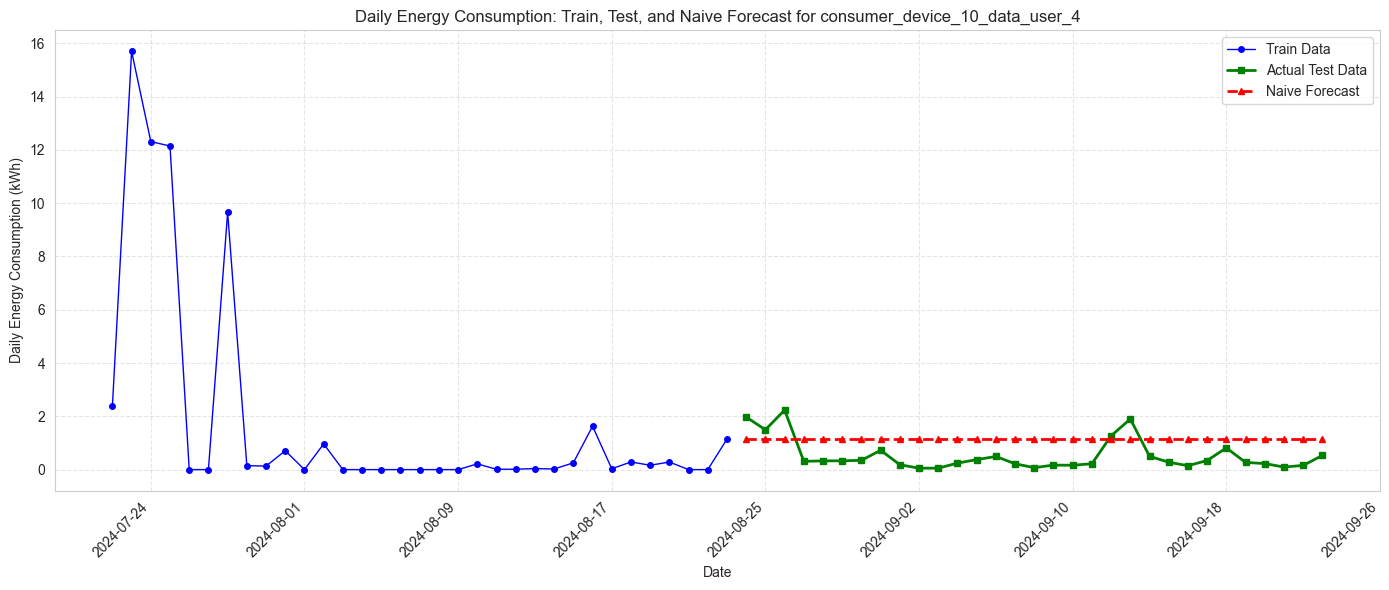

Plot generated successfully.


In [17]:
# --- 4. Check if data exists for the selected user and proceed ---
# We need forecasts and test data to make a meaningful comparison plot
if forecast_user.empty or test_user.empty:
    print(f"Warning: Missing forecasts or test data for user {user_to_plot}. Cannot generate plot.")
else:
    # Sort by date for correct line plotting (essential)
    train_user = train_user.sort_values('ds')
    test_user = test_user.sort_values('ds')
    forecast_user = forecast_user.sort_values('ds')
    # --- 5. Create the Plot ---
    plt.figure(figsize=(14, 6))

    # Plot Training Data (if available)
    if not train_user.empty:
        plt.plot(train_user['ds'], train_user['y'], label='Train Data', color='blue', marker='o', linestyle='-', linewidth=1, markersize=4)
        print("Plotted Train Data.")

    # Plot Test Data (Actuals) - This is the actual historical data for the test period
    plt.plot(test_user['ds'], test_user['actual_y'], label='Actual Test Data', color='green', marker='s', linestyle='-', linewidth=2, markersize=4)
    print("Plotted Actual Test Data.")

    # Plot Forecasts - These are the model's predictions for the test period
    plt.plot(forecast_user['ds'], forecast_user['Naive'], label='Naive Forecast', color='red', marker='^', linestyle='--', linewidth=2, markersize=4)
    print("Plotted Naive Forecast.")

    # --- 6. Formatting ---
    plt.xlabel('Date')
    plt.ylabel('Daily Energy Consumption (kWh)')
    plt.title(f'Daily Energy Consumption: Train, Test, and Naive Forecast for {user_to_plot}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- Crucial: Set x-axis limits to include all relevant periods ---
    # Find the overall min and max dates to display across all available series
    all_series_to_plot = [test_user['ds'], forecast_user['ds']] # Always include test and forecast
    if not train_user.empty:
        all_series_to_plot.append(train_user['ds']) # Include train if it exists

    all_dates = pd.concat(all_series_to_plot).dropna()
    if not all_dates.empty:
        x_min = all_dates.min()
        x_max = all_dates.max()
        # Add a small buffer for better visualization
        buffer_days = max(2, int((x_max - x_min).days * 0.05)) # 5% buffer or at least 2 days
        plt.xlim(left=x_min - pd.Timedelta(days=buffer_days), right=x_max + pd.Timedelta(days=buffer_days))
        print(f"Set x-axis limits from ~{x_min.date()} to ~{x_max.date()}")
    else:
        print("Warning: Could not determine date range for x-axis.")

    # Improve date formatting on the x-axis for better readability
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) # Adjust number of ticks if needed
    plt.xticks(rotation=45, ha='right') # Rotate labels

    # --- 7. Display the Plot ---
    plt.tight_layout() # Adjust layout to prevent clipping of labels
    plt.show()

    print("Plot generated successfully.")